# Serrazanetti Matteo

# Applied Machine Learning Project (Basic and Advance) 

# Articles topic recognition model using **CNN** and **Decision Tree (DT)**

#Basic operation (link to drive and library import)

In [34]:
#import data from drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
import os
import re
import string 
import pandas as pd
import numpy as np
import sklearn
import nltk
import matplotlib.pyplot as plt
import statistics
from scipy.stats import sem
from wordcloud import WordCloud
from graphviz import Source
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier,VotingClassifier   
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler,normalize
from sklearn.tree import export_graphviz
from sklearn.model_selection import cross_val_score
from sklearn import tree
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, MaxPooling1D, Conv1D, Flatten, Dropout



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Dataset exploration

In these cells extract files and expole them creating variables that will be necessary in the following operations

In [36]:
df_train = pd.read_csv('drive/MyDrive/MLproject-articles/train.csv')
category_list = ['Computer_Science','Physics','Mathematics','Statistics','Quantitative_Biology','Quantitative_Finance']
category_dict = {0:'Computer_Science',1:'Physics',2:'Mathematics',3:'Statistics',4:'Quantitative_Biology',5:'Quantitative_Finance'} 
#This dictionary will be necessary in the analysis using the Decision Tree
df_categories_train = df_train[['Computer Science','Physics','Mathematics','Statistics','Quantitative Biology','Quantitative Finance']] 
#if ID is n index is n-1

title_list_train = [title for title in df_train.TITLE]
id_list_train = [id for id in df_train.ID]
abstract_list_train = [abstract for abstract in df_train.ABSTRACT]

In [37]:
final_categories_list_train = []
for index, row in df_categories_train.iterrows():
    n=0
    final_categories_list_train.append([row[n],row[n+1],row[n+2],row[n+3],row[n+4],row[n+5]])
    n+=6
final_categories_array = np.array(final_categories_list_train)
#this array contains the information for data labeling (multi-labeling to be precise)

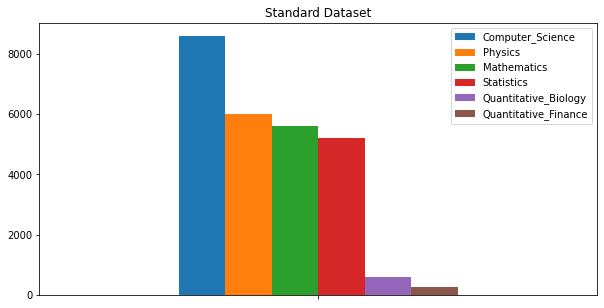

In [38]:
count_dict = {'Computer_Science':0,'Physics':0,'Mathematics':0,'Statistics':0,'Quantitative_Biology':0,'Quantitative_Finance':0}
for i in final_categories_list_train:
  for j in range(len(i)):
    if i[j]==1:
      count_dict[category_list[j]] += 1
count_df = pd.DataFrame(count_dict, index=[''])
count_df.plot.bar(figsize=(10,5), title = 'Standard Dataset')

This plots describe the distribution of articles among the different categories, displaying a huge difference in numbers

This skewed class problem is probably the reason of the low accuracy in relation to the AUC obtained by the model.

# Articles Title Analysis

##Title dataset encoding, exploration and division between test and training set

In [39]:
title_word_list_train = [] #title_word_list[n] is the list with all the words of the title of the article with ID n+1
re_punc = re.compile('[%s]' % re.escape(string.punctuation))
stop_words = stopwords.words('english')
porter = PorterStemmer()
for title in title_list_train:
  #split title
  init_words = []
  for word in title.split():
    init_words.append(word)
  #remove punctuation
  naked_words = [re_punc.sub('', w) for w in init_words]
  #remove numbers
  only_words = [word for word in naked_words if word.isalpha()]
  #remove stopwords
  nostop_words = [word for word in only_words if word not in stop_words ]
  #stemming
  stemmed_words = [porter.stem(word) for word in nostop_words] 
  title_word_list_train.append(stemmed_words)

#check how many words have been excluded by these procedures
count_before = 0
for i in title_list_train:
  count_before+=len(i)
print('Number of words in titles before these operations:',count_before)
count_after = 0
for i in title_word_list_train:
  count_after+=len(i)
print('Number of words in titles after these operations:',count_after)

#articles with ID 8271 and 16453 can not be analyzed using the title because 
#after the analysis the title is empty. So i will fill it with 'none'

count=0
for i in title_word_list_train:
  count+=1
  if len(i)==0 and count!=0:
    #print('Before:',title_word_list_train[count-1])
    title_word_list_train[count-1] = ['none']
    #print('After:',title_word_list_train[count-1])

text_train = [] #text needs to be a list of all the titles as strings
for title in title_word_list_train:
  text_train.append(' '.join(title))

max_features = 4096
vectorizer = TfidfVectorizer(max_features=max_features)
vectorizer.fit(text_train)

encoded_vectors_train_list = []
for i in range(len(text_train)):
  try:
    i=[text_train[i]] #need to be a raw string, possible calling the object of a list with a single element
    vector = vectorizer.transform(i)
    X = vector.toarray()
    encoded_vectors_train_list.append(X)
  except IndexError:
    continue

encoded_vectors_train_array = np.array(encoded_vectors_train_list)

Number of words in titles before these operations: 1528811
Number of words in titles after these operations: 153153


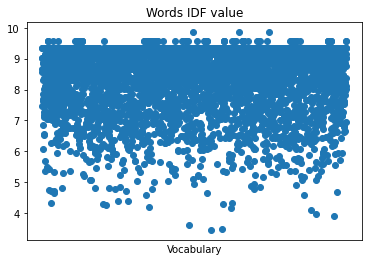

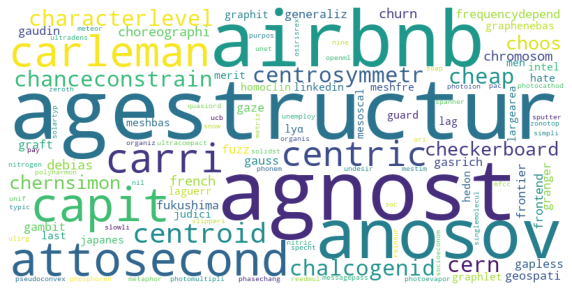

In [40]:
#plot the distribution of the idf values
fig, ax = plt.subplots()
plt.scatter(y=vectorizer.idf_, x=vectorizer.vocabulary_.keys()) #i used only the length of the list to plot (info on x not useful)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax.set_xlabel('Vocabulary')
ax.set_title('Words IDF value')

#Extract the most "important" words, considering the IDF value (those with value over 9.5, i derived this value from the plot) and use them to create a cloud plot.
vocabulary_values_list = list(vectorizer.vocabulary_.values())
vocabulary_keys_list = list(vectorizer.vocabulary_.keys())
important_words_list = []
for i in enumerate(vectorizer.idf_):
  if i[1] > 9.5:
    ind = vocabulary_values_list.index(i[0])
    important_words_list.append(vocabulary_keys_list[ind])

important_words_string = ' '.join(important_words_list)
wordcloud = WordCloud(width = 800, height = 400,
                background_color ='white',
                min_font_size = 10).generate(important_words_string)                     
plt.figure(figsize = (10, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [41]:
max_len = 20972
n = 0.7

'''TRAINING SET DEFINITION'''
x_train = encoded_vectors_train_array[0:int(n*max_len)]
y_train_OHE = final_categories_array[0:int(n*max_len)]
y_train = []
for i in y_train_OHE:
  y_train.append(category_dict[list(i).index(1)])

'''TEST SET DEFINITION'''
x_test = np.array(encoded_vectors_train_array[int(n*max_len):])
y_test_OHE = np.array(final_categories_array[int(n*max_len):])
y_test = []
for i in y_test_OHE:
  y_test.append(category_dict[list(i).index(1)])

##CNN

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 4096, 16)          96        
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 512, 16)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 512, 16)           1296      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 128, 16)          0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 128, 16)           1296      
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 64, 16)          

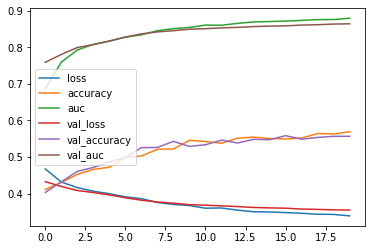

In [42]:
#i need to present the data in the following format (n. elements, max features, 1)
x_train = x_train.reshape(x_train.shape[0],max_features,1)
x_test = x_test.reshape(x_test.shape[0],max_features,1)

#Most of the features have value zero in many different titles so i use a large 
#filter size and also a large pooling number, especially for the first layer where there are more zeros
#I use the same model both for title and abstracts
model=Sequential()
model.add(Conv1D(16, 5, activation='relu', padding='same', input_shape=(max_features,1)))
model.add(MaxPooling1D(8))
model.add(Conv1D(16, 5, activation='relu', padding='same'))
model.add(MaxPooling1D(4))
model.add(Conv1D(16, 5, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(6, activation='sigmoid', name='output'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
model.summary()
#i use a sigmoid activation function and a binary cross-entropy loss function because i have a multi-label analysis

#model selection maximizing the AUC value
checkpoint_filepath_title = 'drive/MyDrive/MLproject-articles/tmp_title/title_checkpoint'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath_title, save_weights_only=True, save_best_only=True, monitor='val_auc', mode='max')

history_callback = model.fit(x_train, y_train_OHE, validation_split=0.7, epochs=20, callbacks=[model_checkpoint_callback], verbose = 0)

#i load the best parameters in the model in order to test the performances in the test set
model.load_weights(checkpoint_filepath_title)
score = model.evaluate(x_test, y_test_OHE, verbose=0)
print('\n\nTest Result')
print('Loss:',score[0],', AUC:', score[2],', Accuracy:', score[1],'\n\n')

#With this line of code i plot the learning process of the model
pd.DataFrame(history_callback.history).plot()

##Decision Tree

Max depth: 15 - Max leaf nodes: 22 - Cross validation value: 0.4921619169568435
Max depth: 15 - Max leaf nodes: 26 - Cross validation value: 0.49114011835456656
Max depth: 15 - Max leaf nodes: 30 - Cross validation value: 0.4911411627824394
Max depth: 17 - Max leaf nodes: 22 - Cross validation value: 0.49591002044989774
Max depth: 17 - Max leaf nodes: 26 - Cross validation value: 0.49590967230727345
Max depth: 17 - Max leaf nodes: 30 - Cross validation value: 0.49454739021844557
Max depth: 19 - Max leaf nodes: 22 - Cross validation value: 0.5017024174327546
Max depth: 19 - Max leaf nodes: 26 - Cross validation value: 0.500679922545229
Max depth: 19 - Max leaf nodes: 30 - Cross validation value: 0.49965812394295195

Best conditions are:
Max depth: 19
Max leaf nodes: 22
Cross validation scores: 0.5108070255129078 ± 0.003711011093383501


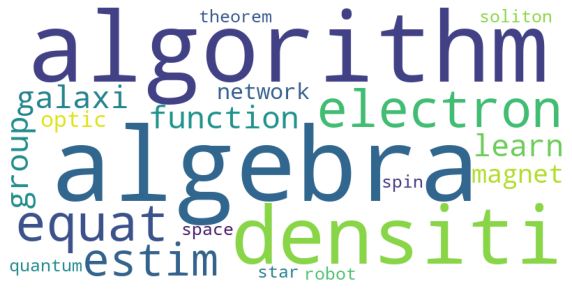

In [43]:
#i need to use x_train and x_test in the correct shape
x_train = x_train.reshape(x_train.shape[0],max_features)
x_test = x_test.reshape(x_test.shape[0],max_features)

#this are the list of parameters optimized with a grid search
max_depth = [15,17,19]#[7,9,11,13,15,17,19]
max_leaf_nodes = [22,26,30]#[6,10,14,18,22,26,30]

best = 0
best_conditions = [0,0]
for i in max_depth:
  for j in max_leaf_nodes:
    tree_clf = DecisionTreeClassifier(max_depth = i, max_leaf_nodes = j)
    #i perform cross-validation dividing train in 2 part 0.8-0.2
    tree_clf.fit(x_train[:int(0.8*len(x_train))], y_train[:int(0.8*len(x_train))])
    cross_val_scores = cross_val_score(tree_clf, x_train[int(0.8*len(x_train)):], y_train[int(0.8*len(x_train)):], verbose = 0, cv=3)
    print('Max depth:',i,'- Max leaf nodes:',j,'- Cross validation value:',statistics.mean(cross_val_scores))
    if statistics.mean(cross_val_scores) > best:
      best_conditions = [i,j]
      best = statistics.mean(cross_val_scores)
print('\nBest conditions are:')
print('Max depth:',best_conditions[0])
print('Max leaf nodes:',best_conditions[1])

tree_clf = DecisionTreeClassifier(max_depth = best_conditions[0], max_leaf_nodes = best_conditions[1])
tree_clf.fit(x_train, y_train)

tree_clf.score(x_test, y_test)
cross_val_scores = cross_val_score(tree_clf, x_test, y_test, cv=10, verbose = 0)
print('Cross validation scores:', statistics.mean(cross_val_scores),'±',sem(cross_val_scores),'\n')

#I have similar performances with all max_leaf_nodes possible values except for 6.
#Instead, increasing the number of max_depth the accuracy increase from 0.45 up to 0.50.

#i can extract the features used by the tree, that are the "most important words" and plot them in a cloud plot
important_words_list_title_tree = []
for i in enumerate(tree_clf.feature_importances_):
  if i[1] > 0:
    ind = vocabulary_values_list.index(i[0])
    important_words_list_title_tree.append(vocabulary_keys_list[ind])

important_words_string_title_tree = ' '.join(important_words_list_title_tree)
wordcloud = WordCloud(width = 800, height = 400,
                background_color ='white',
                min_font_size = 10).generate(important_words_string_title_tree)                     
plt.figure(figsize = (10, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
#This way i can print and save the tree although is very large
export_graphviz(tree_clf, out_file=os.path.join("./title_tree.dot"), class_names=category_list, rounded=True, filled=True)
Source.from_file(os.path.join("./title_tree.dot"))

# Articles Abstract Analysis








##Title dataset encoding, exploration and division between test and training set

In [45]:
abstract_word_list_train = []
re_punc = re.compile('[%s]' % re.escape(string.punctuation))
stop_words = stopwords.words('english')
porter = PorterStemmer()
for abstract in abstract_list_train:
  #split abstract
  init_words = [word for word in abstract.split()]
  #remove links (different than in title)
  words_nolink = [w for w in init_words if not re.match(r"http",w)]
  #remove punctuation
  naked_words = [re_punc.sub('', w) for w in words_nolink]
  #remove numbers
  only_words = [word for word in naked_words if word.isalpha()]
  #remove stopwords
  nostop_words = [word for word in only_words if word not in stop_words ]
  #stemming
  stemmed_words = [porter.stem(word) for word in nostop_words] 
  abstract_word_list_train.append(stemmed_words)

#check how many words have been excluded by these procedures
count_before = 0
for i in abstract_list_train:
  count_before+=len(i)
print('Number of words in abstracts before these operations:',count_before)
count_after = 0
for i in abstract_word_list_train:
  count_after+=len(i)
print('Number of words in abstracts after these operations:',count_after)

#check if there are abstract of lenght 0 and substitute them with ['none'] -> all are OK in this case
count=0
for i in abstract_word_list_train:
  count+=1
  if len(i)==0 and count!=0:
    #print('Before:',abstract_word_list_train[count-1])
    abstract_word_list_train[count-1] = ['none']
    #print('After:',abstract_word_list_train[count-1])

text_ab_train = [] #text needs to be a list of all the abstracts as strings
for abstract in abstract_word_list_train:
  text_ab_train.append(' '.join(abstract))

max_features_ab = 4096
vectorizer = TfidfVectorizer(max_features=max_features_ab)
vectorizer.fit(text_ab_train)

encoded_ab_vectors_train_list = []
for i in range(len(text_ab_train)):
  try:
    i=[text_ab_train[i]] #need to be a raw string, possible calling the object of a list with a single element
    vector = vectorizer.transform(i)
    X = vector.toarray()
    encoded_ab_vectors_train_list.append(X)
  except IndexError:
    continue

encoded_ab_vectors_train_array = np.array(encoded_ab_vectors_train_list)

Number of words in abstracts before these operations: 21162916
Number of words in abstracts after these operations: 1950633


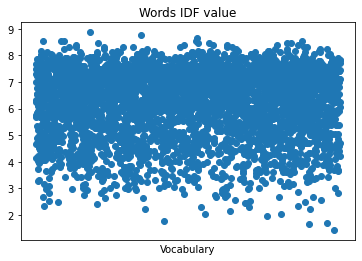

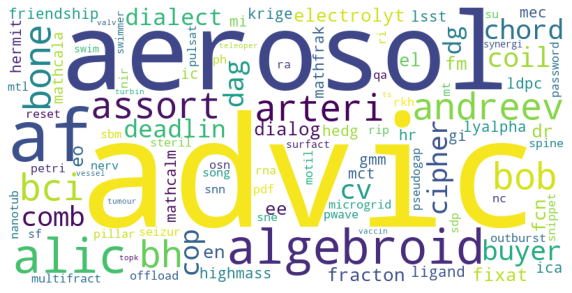

In [46]:
#plot the distribution of the idf values
fig, ax = plt.subplots()
plt.scatter(y=vectorizer.idf_, x=vectorizer.vocabulary_.keys()) #i used only the length of the list to plot (info on x not useful)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax.set_xlabel('Vocabulary')
ax.set_title('Words IDF value')

#Extract the most "important" words (in reality the), those with idf value over 8 (number derived from the distribution plot)
vocabulary_values_list = list(vectorizer.vocabulary_.values())
vocabulary_keys_list = list(vectorizer.vocabulary_.keys())
important_words_list = []
for i in enumerate(vectorizer.idf_):
  if i[1] > 8:
    ind = vocabulary_values_list.index(i[0])
    important_words_list.append(vocabulary_keys_list[ind])

important_words_string = ' '.join(important_words_list)
wordcloud = WordCloud(width = 800, height = 400,
                background_color ='white',
                min_font_size = 10).generate(important_words_string)                     
plt.figure(figsize = (10, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [47]:
max_len = 20972 #substitue with the length of the abstract list length
n = 0.7
'''TRAINING SET DEFINITION'''
x_train_ab = encoded_ab_vectors_train_array[0:int(n*max_len)]
y_train_OHE_ab = final_categories_array[0:int(n*max_len)]
#this y_train_ab varaible is necessary in the decision tree model because of difficulty in recognizing the cateogries in the other format that os not a OHE
y_train_ab = []
for i in y_train_OHE_ab:
  y_train_ab.append(category_dict[list(i).index(1)])
'''TEST SET DEFINITION''' 
x_test_ab = np.array(encoded_ab_vectors_train_array[int(n*max_len):])
y_test_OHE_ab = np.array(final_categories_array[int(n*max_len):])
#y-test_ab has been created for the saem reason as y_train
y_test_ab = []
for i in y_test_OHE_ab:
  y_test_ab.append(category_dict[list(i).index(1)])

##CNN

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 4096, 16)          96        
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 512, 16)          0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 512, 16)           1296      
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 128, 16)          0         
 g1D)                                                            
                                                                 
 conv1d_11 (Conv1D)          (None, 128, 32)           2592      
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 64, 32)          

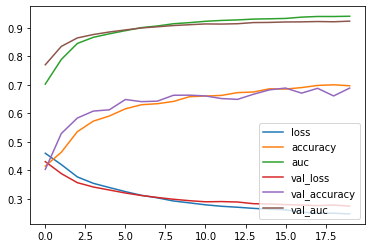

In [48]:
#i need to present the data in the following format (n. elements, max features, 1)
x_train_ab = x_train_ab.reshape(x_train_ab.shape[0],max_features_ab,1)
x_test_ab = x_test_ab.reshape(x_test_ab.shape[0],max_features_ab,1)

#The same idea for the title analysis is used here
model=Sequential()
model.add(Conv1D(16, 5, activation='relu', padding='same', input_shape=(max_features_ab,1)))
model.add(MaxPooling1D(8))
model.add(Conv1D(16, 5, activation='relu', padding='same'))
model.add(MaxPooling1D(4))
model.add(Conv1D(32, 5, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(6, activation='sigmoid', name='output'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
model.summary()
#i use a sigmoid activation function and a binary cross-entropy loss function because i have a multi-label analysis

#model selection maximizing the AUC value
checkpoint_filepath_abstract = 'drive/MyDrive/MLproject-articles/tmp_abstract/abstract_checkpoint'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath_abstract, save_weights_only=True, save_best_only=True, monitor='val_auc', mode='max')

history_callback = model.fit(x_train_ab, y_train_OHE_ab, validation_split=0.7, epochs=20, callbacks=[model_checkpoint_callback], verbose = 0)

#load the best parameters
model.load_weights(checkpoint_filepath_abstract)
score_ab = model.evaluate(x_test_ab, y_test_OHE_ab, verbose=0)
print('\n\nTest Result')
print('Loss:',score_ab[0],', AUC:', score_ab[2],', Accuracy:', score_ab[1],'\n\n')

pd.DataFrame(history_callback.history).plot()
#plot the training procedures

##Decision Tree

In [ ]:
#i need to use x_train and x_test in the correct shape
x_train_ab = x_train_ab.reshape(x_train_ab.shape[0],max_features_ab)
x_test_ab = x_test_ab.reshape(x_test_ab.shape[0],max_features_ab)

#this are the list of parameters to be optimized in the grid search
max_depth = [7,9,11]#,13,15,17,19]
max_leaf_nodes = [6,10,14]#,18,22,26,30]

#parameters optimization
best = 0
best_conditions_ab = [0,0]
for i in max_depth:
  for j in max_leaf_nodes:
    tree_clf_ab = DecisionTreeClassifier(max_depth = i, max_leaf_nodes = j)
    #i perform cross-validation dividing train in 2 part 0.8-0.2
    tree_clf_ab.fit(x_train_ab[:int(0.8*len(x_train))], y_train_ab[:int(0.8*len(x_train))])
    cross_val_scores_ab = cross_val_score(tree_clf_ab, x_train_ab[int(0.8*len(x_train)):], y_train_ab[int(0.8*len(x_train)):], cv=5, verbose = 0)
    #print('Max depth:',i,'- Max leaf nodes:',j,'- Cross validation value:',statistics.mean(cross_val_scores_ab))
    if statistics.mean(cross_val_scores_ab) > best:
      best_conditions_ab = [i,j]
      best = statistics.mean(cross_val_scores_ab)
print('\nBest conditions are:')
print('Max depth:',best_conditions_ab[0])
print('Max leaf nodes:',best_conditions_ab[1])

tree_clf_ab = DecisionTreeClassifier(max_depth = best_conditions_ab[0], max_leaf_nodes = best_conditions_ab[1])
tree_clf_ab.fit(x_train_ab, y_train_ab)

tree_clf_ab.score(x_test_ab, y_test_ab)
cross_val_scores_ab = cross_val_score(tree_clf_ab, x_test_ab, y_test_ab, cv=10, verbose = 0)
print('\nCross validation scores on test:', statistics.mean(cross_val_scores_ab),'±',sem(cross_val_scores_ab),'\n')
#I have similar performances with all max_leaf_nodes possible values except for 6 like in the title analysis
#Instead, increasing the number of max_depth the accuracy increase up to 0.70.

#cloud plot of the extracted important words for the decision tree classifier
important_words_list_abstract_tree = []
for i in enumerate(tree_clf.feature_importances_):
  if i[1] > 0:
    ind = vocabulary_values_list.index(i[0])
    important_words_list_abstract_tree.append(vocabulary_keys_list[ind])

important_words_string_abstract_tree = ' '.join(important_words_list_abstract_tree)
wordcloud = WordCloud(width = 800, height = 400,
                background_color ='white',
                min_font_size = 10).generate(important_words_string_abstract_tree)                     
plt.figure(figsize = (10, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
export_graphviz(tree_clf_ab, out_file=os.path.join("./abstract_tree.dot"), class_names=category_list, rounded=True, filled=True)
Source.from_file(os.path.join("./abstract_tree.dot"))

#Models evaluation and comparison

Title analysis results:

CNN -> Loss = 0.3480, AUC = 0.8710, Accuracy = 0.5764 

DT  -> Best conditions are max depth = 19, max leaf nodes = 22 and
cross validation scores on test is 0.5108 ± 0.0037

Abstract analysis results:

CNN -> Loss = 0.2665, AUC = 0.9333, Accuracy = 0.7022

DT  -> Best conditions are max depth = 15, max leaf nodes = 26 and
cross validation scores on test is 0.6383 ± 0.0060

Comparing the two different methods, Decision Tree have an accuracy value lower than CNN of about 6/7 points; so it's generally worse especially considering the fact that although CNN has a low accuracy, it has a very high AUC.

Comparing the title and the abstract analysis, is possible to see that abstract analysis have higher performances, probably due to an higher amount of data with respect to titles. For example, after the title reduction and stemming some titles were empty or composed by a very little number of words. This caused problem both in training and in predicting their class.

In conclusion CNN is better than DT, as expected, and it's possible to predict the topic of an article using it's abstract with a very high AUC, it's also possible using only the title, but in this case performances decrease although are still remarkable.
